In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import shlex
import textwrap
import os

In [2]:
goi = ['ENSG00000053918',
 'ENSG00000082438',
 'ENSG00000119912',
 'ENSG00000132170',
 'ENSG00000138190',
 'ENSG00000145996',
 'ENSG00000148737',
 'ENSG00000151465',
 'ENSG00000164758',
 'ENSG00000168297',
 'ENSG00000168944',
 'ENSG00000173175',
 'ENSG00000176399',
 'ENSG00000197157',
 'ENSG00000213390']


In [3]:
# Batch Jobs
for gene in goi:
    with open(f"R_{gene}.R", "w+") as f:
        cmd = f"""\
            version
            library(glue)
            library(data.table)
            library(stringr)
            library(lme4)
            library(mvnfast)
            setwd("/scratch/network/cs9095/cs551")
            source("walmart_robin.R")
            print("prelim complete~")

            robin_df <- fread("merged_data/{gene}_merge.tsv")
            names(robin_df) <- c("snp", "gwas_b", "gwas_se", "eqtl_b", "eqtl_se")
            setorder(robin_df, cols="snp")
            n_replicates = 1000
            output <- walmart_robin(robin_df, n_replicates, ld)
            fwrite(list(output), "output_data/{gene}_pval")
            print("done!")
            """

        cmd = textwrap.dedent(cmd)
        f.write(cmd)

    with open(f"slurm_{gene}.sh", "w+") as f:
        cmd = f"""\
            #!/bin/bash
            #SBATCH --mincpus 4
            #SBATCH --mem 24G
            #SBATCH --time 1-0:00:00
            #SBATCH --job-name csl_{gene}

            Rscript R_{gene}.R
            """
        cmd = textwrap.dedent(cmd)
        f.write(cmd)
        
    subprocess.run(f"sbatch slurm_{gene}.sh", shell=True)

Submitted batch job 1953658
Submitted batch job 1953659
Submitted batch job 1953660
Submitted batch job 1953661
Submitted batch job 1953662
Submitted batch job 1953663
Submitted batch job 1953664
Submitted batch job 1953665
Submitted batch job 1953666
Submitted batch job 1953667
Submitted batch job 1953668
Submitted batch job 1953669
Submitted batch job 1953670
Submitted batch job 1953671
Submitted batch job 1953672


In [109]:
store = []
for gene in goi:
    if os.path.exists(f"{gene}_pval"):
        with open(f"{gene}_pval", "r+") as f:
            file = f.read()
            store.append([gene, float(file.strip())])
store = pd.DataFrame(store).sort_values(1, ascending=False)
store = store.rename(columns={0:"ENSEMBL Gene", 1:"p_value"})
# store["ENSEMBL Gene"] = store["ENSEMBL Gene"].str.replace("ENSG", "").astype(int).astype(str)

In [112]:
store.loc[store.p_value <= 0.05]

,ENSEMBL Gene,p_value
12,ENSG00000176399,0.014
3,ENSG00000132170,0.002
5,ENSG00000145996,0.000
9,ENSG00000168297,0.000


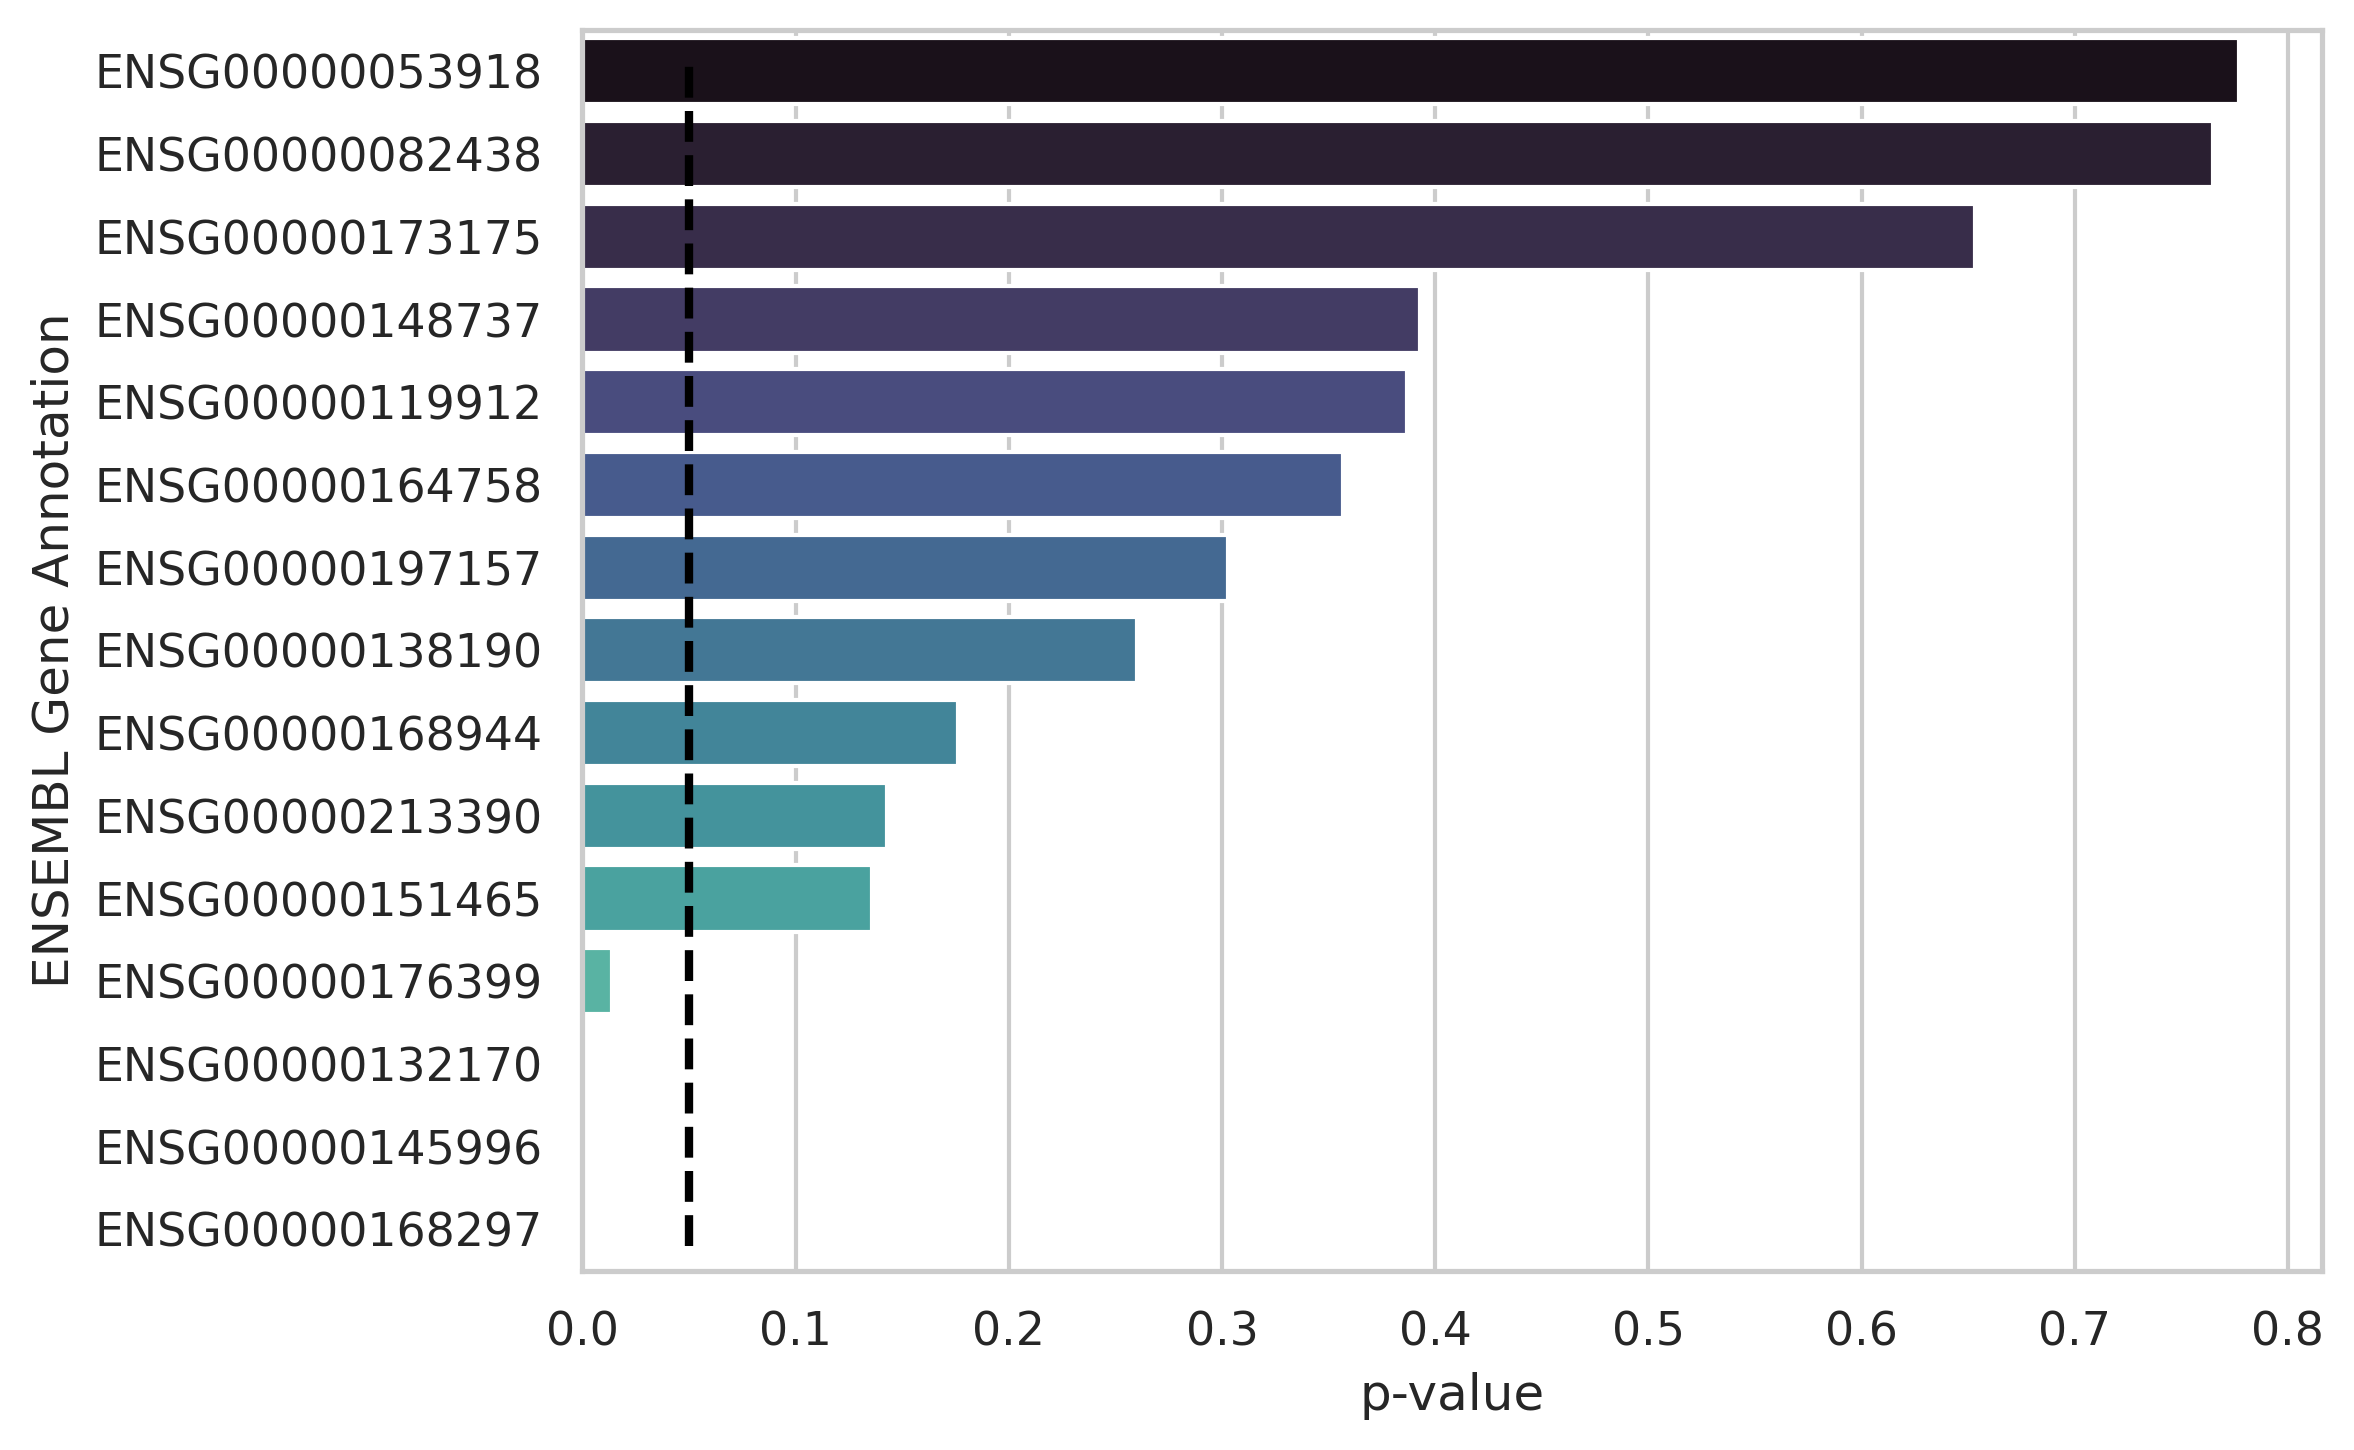

<Figure size 640x480 with 0 Axes>

In [118]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 1, figsize=(8,5), dpi=300)

sns.barplot(x="p_value", y="ENSEMBL Gene", data=store, ax=axes, palette="mako")
plt.tight_layout()
plt.axvline(x=0.05, color='black', ymin=0.02, ymax=0.98, ls='--', lw=2)
# plt.title("Gene Significance", y=1.06)
axes.set(xlabel="p-value", ylabel="ENSEMBL Gene Annotation")
plt.show()